# GPS Data Visualization

This notebook visualizes GPS data from JSON log files, displaying both aggregate statistics and individual log file details.

In [6]:
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install datetime
%pip install matplotlib.dates

Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.0-cp313-cp313-macosx_10_13_universal2.whl.metadata (104 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.0-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.2.1-cp313

In [7]:
import json
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter

# Set matplotlib to display plots inline with larger figure sizes
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')  # Use a nicer style for plots

## Data Loading and Processing Functions

In [8]:
def parse_json_file(file_path):
    """Parse a JSON file containing GPS data line by line"""
    try:
        with open(file_path) as f:
            # Try to parse as line-by-line JSON
            try:
                data = [json.loads(line) for line in f if line.strip()]
                if not data:  # If no data was parsed, try as a single JSON object
                    f.seek(0)
                    data = json.load(f)
                    if isinstance(data, dict):
                        data = [data]
            except json.JSONDecodeError:
                # Try as a single JSON object
                f.seek(0)
                data = json.load(f)
                if isinstance(data, dict):
                    data = [data]
        return data
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return []

def extract_data_from_entries(data):
    """Extract relevant fields from GPS data entries"""
    tpv_data = []
    sky_data = []
    pps_jitter_ns = []

    for entry in data:
        if isinstance(entry, dict):  # Ensure entry is a dictionary
            entry_class = entry.get("class", "")
            
            if entry_class == "TPV" and "lat" in entry and "lon" in entry:
                tpv_data.append({
                    "time": entry.get("time", ""),
                    "lat": entry.get("lat", 0),
                    "lon": entry.get("lon", 0),
                    "alt": entry.get("alt", 0),
                    "eph": entry.get("eph", 0),  # Horizontal position error
                    "epv": entry.get("epv", 0)   # Vertical position error
                })
            elif entry_class == "SKY":
                sky_data.append({
                    "time": entry.get("time", ""),
                    "nSat": entry.get("nSat", 0),
                    "uSat": entry.get("uSat", 0),
                    "hdop": entry.get("hdop", 0),
                    "vdop": entry.get("vdop", 0),
                    "pdop": entry.get("pdop", 0)
                })
            elif entry_class == "PPS":
                jitter = abs(entry.get("clock_nsec", 0) - 0)
                pps_jitter_ns.append({
                    "real_sec": entry.get("real_sec", 0),
                    "jitter_ns": jitter
                })

    # Convert to DataFrames
    df_tpv = pd.DataFrame(tpv_data)
    df_sky = pd.DataFrame(sky_data)
    df_pps = pd.DataFrame(pps_jitter_ns)
    
    # Convert time strings to datetime objects for TPV and SKY data
    if not df_tpv.empty and "time" in df_tpv.columns:
        try:
            df_tpv["datetime"] = pd.to_datetime(df_tpv["time"])
        except:
            print("Could not parse TPV time data")
    
    if not df_sky.empty and "time" in df_sky.columns:
        try:
            df_sky["datetime"] = pd.to_datetime(df_sky["time"])
        except:
            print("Could not parse SKY time data")
    
    return df_tpv, df_sky, df_pps

## Find and Load GPS Log Files

In [9]:
# Get the directory of this notebook
notebook_dir = os.getcwd()

# Find all JSON files in the current directory and subdirectories
json_files = []
for ext in ["*.json"]:
    json_files.extend(glob.glob(os.path.join(notebook_dir, ext)))
    json_files.extend(glob.glob(os.path.join(notebook_dir, "**", ext), recursive=True))

# Remove duplicates and sort
json_files = sorted(list(set(json_files)))

if not json_files:
    print("No JSON files found in the current directory or subdirectories.")
else:
    print(f"Found {len(json_files)} JSON files:")
    for file in json_files:
        print(f"- {os.path.basename(file)}")

Found 7 JSON files:
- almanac_20250513000140.json
- almanac_20250513120001.json
- almanac_20250514000001.json
- almanac_20250514120001.json
- almanac_20250515000001.json
- gps_log.json
- gpt_log_boddeti2.json


## Process All Files for Aggregate Data

In [10]:
# Initialize data storage for aggregation
all_data = {
    "tpv": [],
    "sky": [],
    "pps": []
}

# Process each file to collect data
for file_path in json_files:
    try:
        print(f"Processing file: {os.path.basename(file_path)}")
        data = parse_json_file(file_path)
        if data:
            df_tpv, df_sky, df_pps = extract_data_from_entries(data)
            all_data["tpv"].append(df_tpv)
            all_data["sky"].append(df_sky)
            all_data["pps"].append(df_pps)
        else:
            print(f"No data found in {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

Processing file: almanac_20250513000140.json
Processing file: almanac_20250513120001.json
Processing file: almanac_20250514000001.json
Processing file: almanac_20250514120001.json
Processing file: almanac_20250515000001.json
Processing file: gps_log.json
Processing file: gpt_log_boddeti2.json


## Aggregate Data Visualization

This section displays aggregate statistics across all log files.

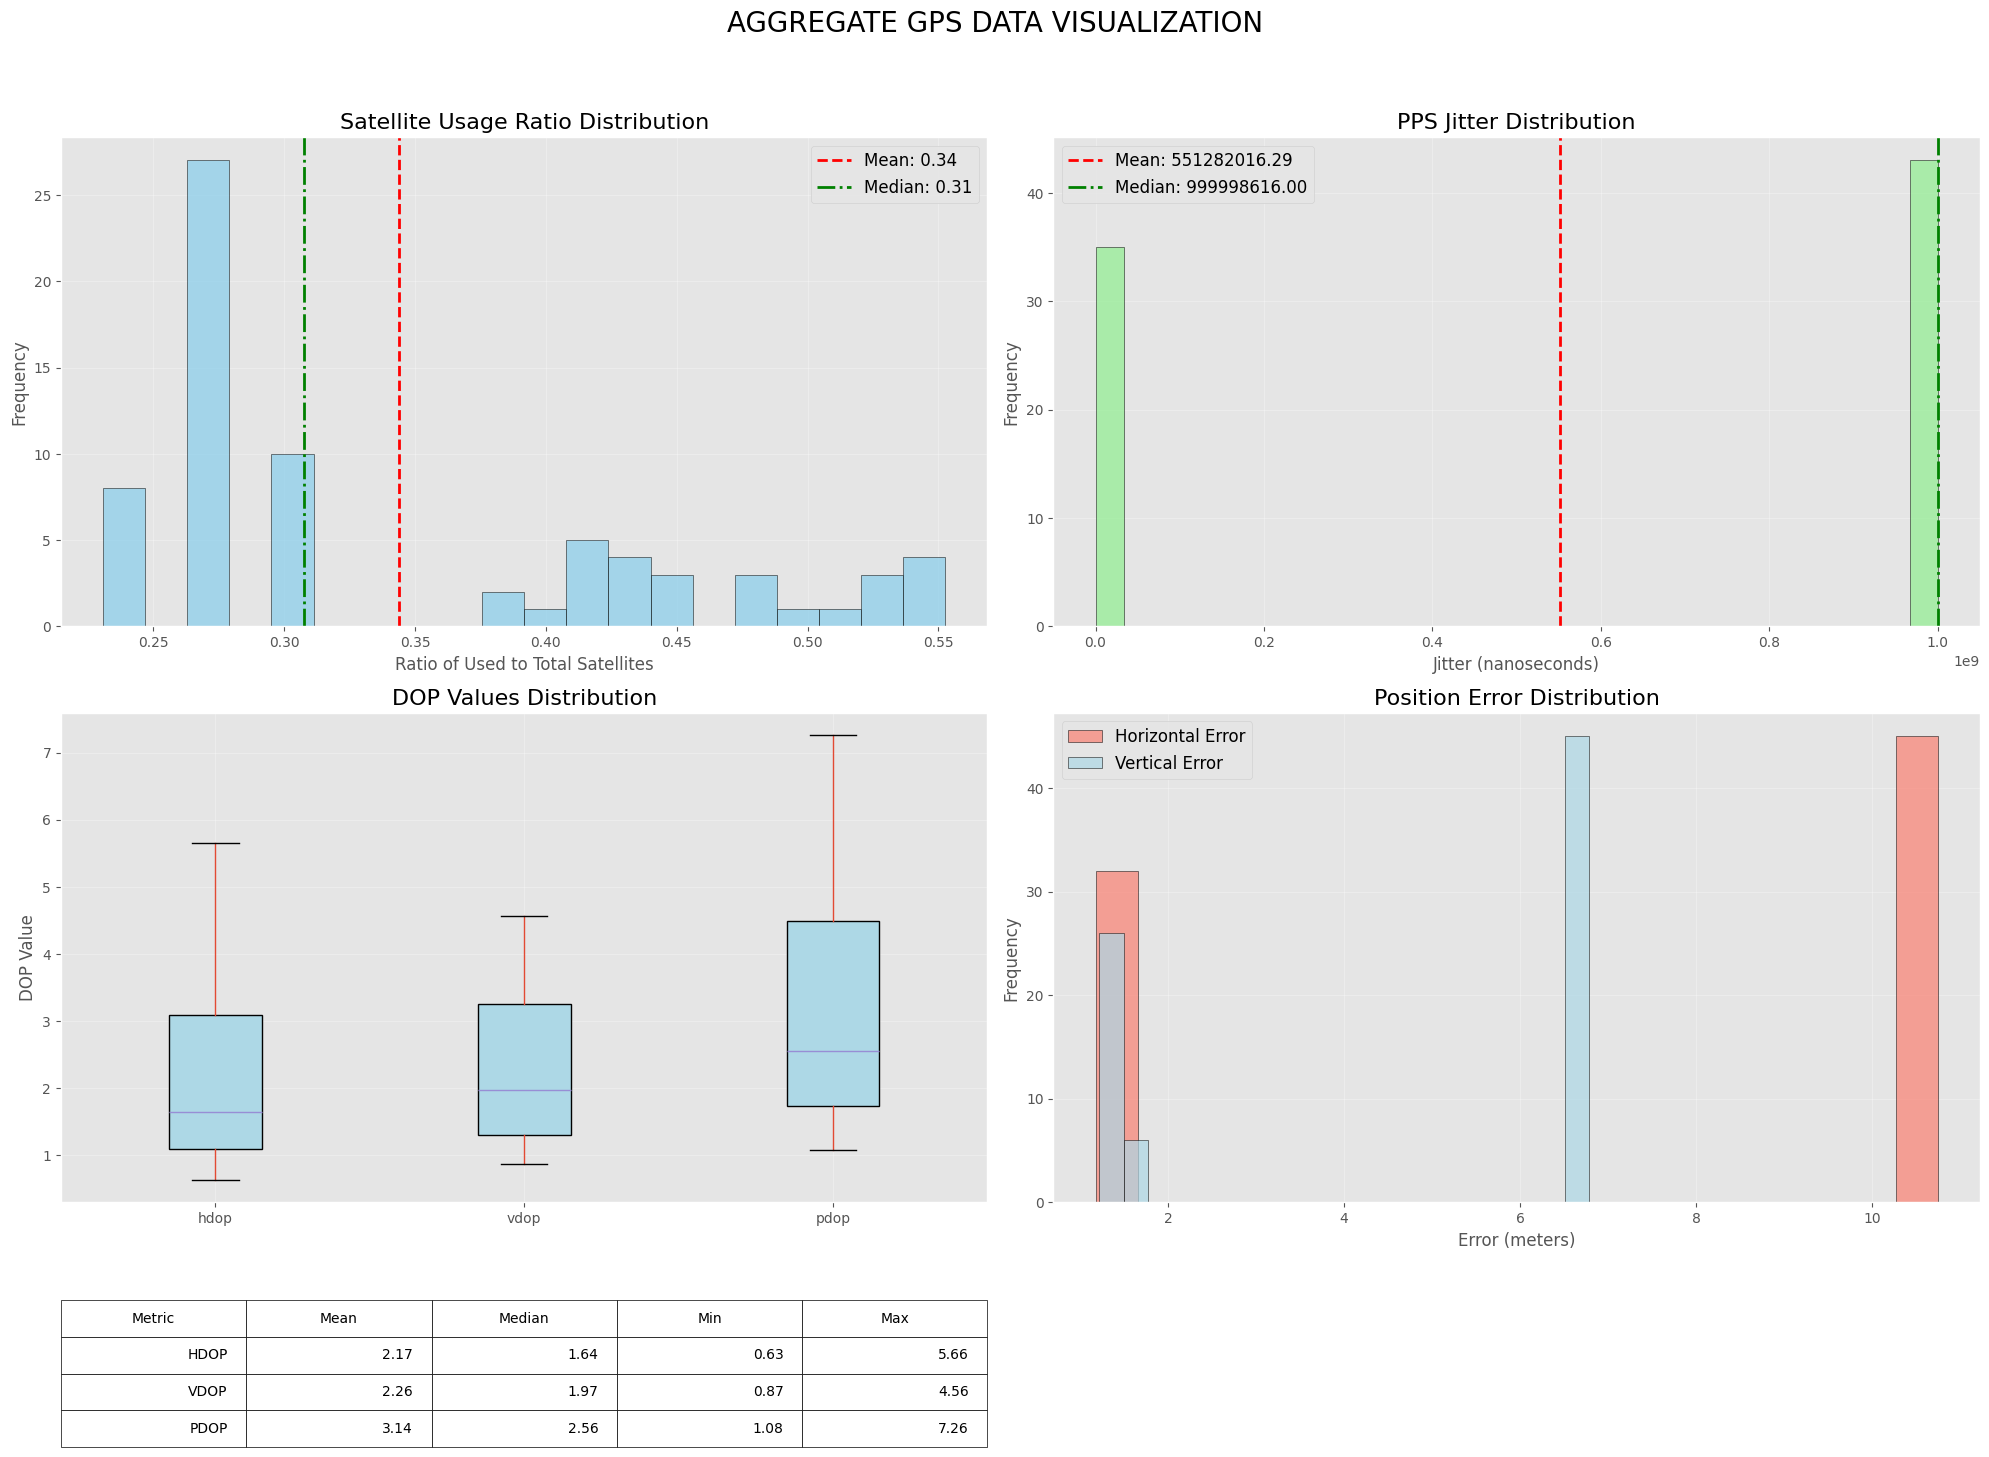

In [11]:
# Combine all dataframes
combined_tpv = pd.concat(all_data["tpv"]) if all_data["tpv"] else pd.DataFrame()
combined_sky = pd.concat(all_data["sky"]) if all_data["sky"] else pd.DataFrame()
combined_pps = pd.concat(all_data["pps"]) if all_data["pps"] else pd.DataFrame()

if combined_tpv.empty and combined_sky.empty and combined_pps.empty:
    print("No data available for aggregate plots")
else:
    # Create a figure with subplots for aggregate data
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle("AGGREGATE GPS DATA VISUALIZATION", fontsize=20, y=0.98)
    
    # Plot 1: Satellite Usage Statistics
    if not combined_sky.empty and "nSat" in combined_sky.columns and "uSat" in combined_sky.columns:
        ax1 = fig.add_subplot(2, 2, 1)
        
        # Calculate satellite usage ratio
        if not combined_sky["nSat"].empty and (combined_sky["nSat"] > 0).any():
            combined_sky["usage_ratio"] = combined_sky["uSat"] / combined_sky["nSat"]
            
            # Create histogram of satellite usage ratio
            ax1.hist(combined_sky["usage_ratio"], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            ax1.set_title("Satellite Usage Ratio Distribution", fontsize=16)
            ax1.set_xlabel("Ratio of Used to Total Satellites", fontsize=12)
            ax1.set_ylabel("Frequency", fontsize=12)
            ax1.grid(True, alpha=0.3)
            
            # Add mean and median lines
            mean_ratio = combined_sky["usage_ratio"].mean()
            median_ratio = combined_sky["usage_ratio"].median()
            ax1.axvline(mean_ratio, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.2f}')
            ax1.axvline(median_ratio, color='g', linestyle='-.', linewidth=2, label=f'Median: {median_ratio:.2f}')
            ax1.legend(fontsize=12)
    
    # Plot 2: PPS Jitter Statistics
    if not combined_pps.empty and "jitter_ns" in combined_pps.columns:
        ax2 = fig.add_subplot(2, 2, 2)
        
        # Create histogram of jitter values
        ax2.hist(combined_pps["jitter_ns"], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        ax2.set_title("PPS Jitter Distribution", fontsize=16)
        ax2.set_xlabel("Jitter (nanoseconds)", fontsize=12)
        ax2.set_ylabel("Frequency", fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Add mean and median lines
        mean_jitter = combined_pps["jitter_ns"].mean()
        median_jitter = combined_pps["jitter_ns"].median()
        ax2.axvline(mean_jitter, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_jitter:.2f}')
        ax2.axvline(median_jitter, color='g', linestyle='-.', linewidth=2, label=f'Median: {median_jitter:.2f}')
        ax2.legend(fontsize=12)
    
    # Plot 3: DOP Values Box Plot
    if not combined_sky.empty:
        dop_columns = [col for col in ["hdop", "vdop", "pdop"] if col in combined_sky.columns]
        if dop_columns:
            ax3 = fig.add_subplot(2, 2, 3)
            combined_sky[dop_columns].boxplot(ax=ax3, patch_artist=True, boxprops=dict(facecolor='lightblue'))
            ax3.set_title("DOP Values Distribution", fontsize=16)
            ax3.set_ylabel("DOP Value", fontsize=12)
            ax3.grid(True, alpha=0.3)
            
            # Add a table with statistics
            stats_data = []
            for col in dop_columns:
                stats_data.append([
                    col.upper(),
                    f"{combined_sky[col].mean():.2f}",
                    f"{combined_sky[col].median():.2f}",
                    f"{combined_sky[col].min():.2f}",
                    f"{combined_sky[col].max():.2f}"
                ])
            
            ax3.table(
                cellText=stats_data,
                colLabels=["Metric", "Mean", "Median", "Min", "Max"],
                loc="bottom",
                bbox=[0.0, -0.5, 1.0, 0.3]
            )
            ax3.set_xlabel("")  # Remove x-label as table provides context
    
    # Plot 4: Position Error Statistics
    if not combined_tpv.empty:
        error_columns = [col for col in ["eph", "epv"] if col in combined_tpv.columns]
        if error_columns:
            ax4 = fig.add_subplot(2, 2, 4)
            
            colors = ['salmon', 'lightblue']
            for i, col in enumerate(error_columns):
                if combined_tpv[col].notna().any():
                    label = "Horizontal Error" if col == "eph" else "Vertical Error"
                    ax4.hist(combined_tpv[col], bins=20, alpha=0.7, label=label, color=colors[i], edgecolor='black')
            
            ax4.set_title("Position Error Distribution", fontsize=16)
            ax4.set_xlabel("Error (meters)", fontsize=12)
            ax4.set_ylabel("Frequency", fontsize=12)
            ax4.legend(fontsize=12)
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()

## Individual Log File Visualizations

This section displays detailed visualizations for each log file.

In [12]:
def plot_gps_data(file_path):
    """Plot GPS data from a single file"""
    print(f"\n## Visualizing: {os.path.basename(file_path)} ##")
    data = parse_json_file(file_path)
    
    if not data:
        print(f"No data found in {file_path}")
        return None
    
    df_tpv, df_sky, df_pps = extract_data_from_entries(data)
    
    # Skip plotting if any dataframe is empty
    if df_tpv.empty and df_sky.empty and df_pps.empty:
        print(f"No relevant data found in {file_path}")
        return None
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f"GPS Data Visualization - {os.path.basename(file_path)}", fontsize=20, y=0.98)
    
    # Plot 1: GPS Location (if data exists)
    if not df_tpv.empty and "lon" in df_tpv.columns and "lat" in df_tpv.columns:
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.plot(df_tpv["lon"], df_tpv["lat"], marker="o", linestyle="-", markersize=5, color='blue', alpha=0.7)
        ax1.set_title("GPS Location Trace", fontsize=16)
        ax1.set_xlabel("Longitude", fontsize=12)
        ax1.set_ylabel("Latitude", fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Add error bars if available
        if "eph" in df_tpv.columns and df_tpv["eph"].notna().any():
            # Sample every 10th point to avoid cluttering
            sample_idx = np.arange(0, len(df_tpv), 10)
            if len(sample_idx) > 0:
                ax1.errorbar(
                    df_tpv.iloc[sample_idx]["lon"], 
                    df_tpv.iloc[sample_idx]["lat"],
                    xerr=df_tpv.iloc[sample_idx]["eph"] / 111000,  # Approximate conversion to degrees
                    yerr=df_tpv.iloc[sample_idx]["eph"] / 111000,
                    fmt='none', ecolor='r', alpha=0.3
                )
    
    # Plot 2: Satellite Count (if data exists)
    if not df_sky.empty and "nSat" in df_sky.columns and "uSat" in df_sky.columns:
        ax2 = fig.add_subplot(2, 2, 2)
        
        if "datetime" in df_sky.columns:
            ax2.plot(df_sky["datetime"], df_sky["nSat"], label="Total Satellites", linewidth=2, color='blue')
            ax2.plot(df_sky["datetime"], df_sky["uSat"], label="Used Satellites", linewidth=2, color='green')
            ax2.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
        else:
            # If datetime conversion failed, use index
            ax2.plot(df_sky.index, df_sky["nSat"], label="Total Satellites", linewidth=2, color='blue')
            ax2.plot(df_sky.index, df_sky["uSat"], label="Used Satellites", linewidth=2, color='green')
        
        ax2.set_title("Satellite Count Over Time", fontsize=16)
        ax2.set_xlabel("Time", fontsize=12)
        ax2.set_ylabel("Number of Satellites", fontsize=12)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: PPS Jitter (if data exists)
    if not df_pps.empty and "jitter_ns" in df_pps.columns:
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(df_pps["real_sec"], df_pps["jitter_ns"], linewidth=2, color='purple')
        ax3.set_title("PPS Jitter Over Time", fontsize=16)
        ax3.set_xlabel("Real Time (s)", fontsize=12)
        ax3.set_ylabel("Jitter (nanoseconds)", fontsize=12)
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: DOP Values (if data exists)
    if not df_sky.empty and "hdop" in df_sky.columns and "vdop" in df_sky.columns:
        ax4 = fig.add_subplot(2, 2, 4)
        
        colors = ['red', 'blue', 'green']
        if "datetime" in df_sky.columns:
            ax4.plot(df_sky["datetime"], df_sky["hdop"], label="HDOP", linewidth=2, color=colors[0])
            ax4.plot(df_sky["datetime"], df_sky["vdop"], label="VDOP", linewidth=2, color=colors[1])
            if "pdop" in df_sky.columns:
                ax4.plot(df_sky["datetime"], df_sky["pdop"], label="PDOP", linewidth=2, color=colors[2])
            ax4.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
        else:
            # If datetime conversion failed, use index
            ax4.plot(df_sky.index, df_sky["hdop"], label="HDOP", linewidth=2, color=colors[0])
            ax4.plot(df_sky.index, df_sky["vdop"], label="VDOP", linewidth=2, color=colors[1])
            if "pdop" in df_sky.columns:
                ax4.plot(df_sky.index, df_sky["pdop"], label="PDOP", linewidth=2, color=colors[2])
        
        ax4.set_title("Dilution of Precision (DOP) Values", fontsize=16)
        ax4.set_xlabel("Time", fontsize=12)
        ax4.set_ylabel("DOP Value", fontsize=12)
        ax4.legend(fontsize=12)
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()
    
    # Print some statistics
    print("\nStatistics:")
    if not df_tpv.empty:
        print(f"TPV Records: {len(df_tpv)}")
    if not df_sky.empty:
        print(f"SKY Records: {len(df_sky)}")
        if "nSat" in df_sky.columns:
            print(f"Average satellites visible: {df_sky['nSat'].mean():.2f}")
        if "uSat" in df_sky.columns:
            print(f"Average satellites used: {df_sky['uSat'].mean():.2f}")
    if not df_pps.empty:
        print(f"PPS Records: {len(df_pps)}")
        if "jitter_ns" in df_pps.columns:
            print(f"Average jitter: {df_pps['jitter_ns'].mean():.2f} ns")
    print("\n" + "-"*50)


## Visualizing: almanac_20250513000140.json ##


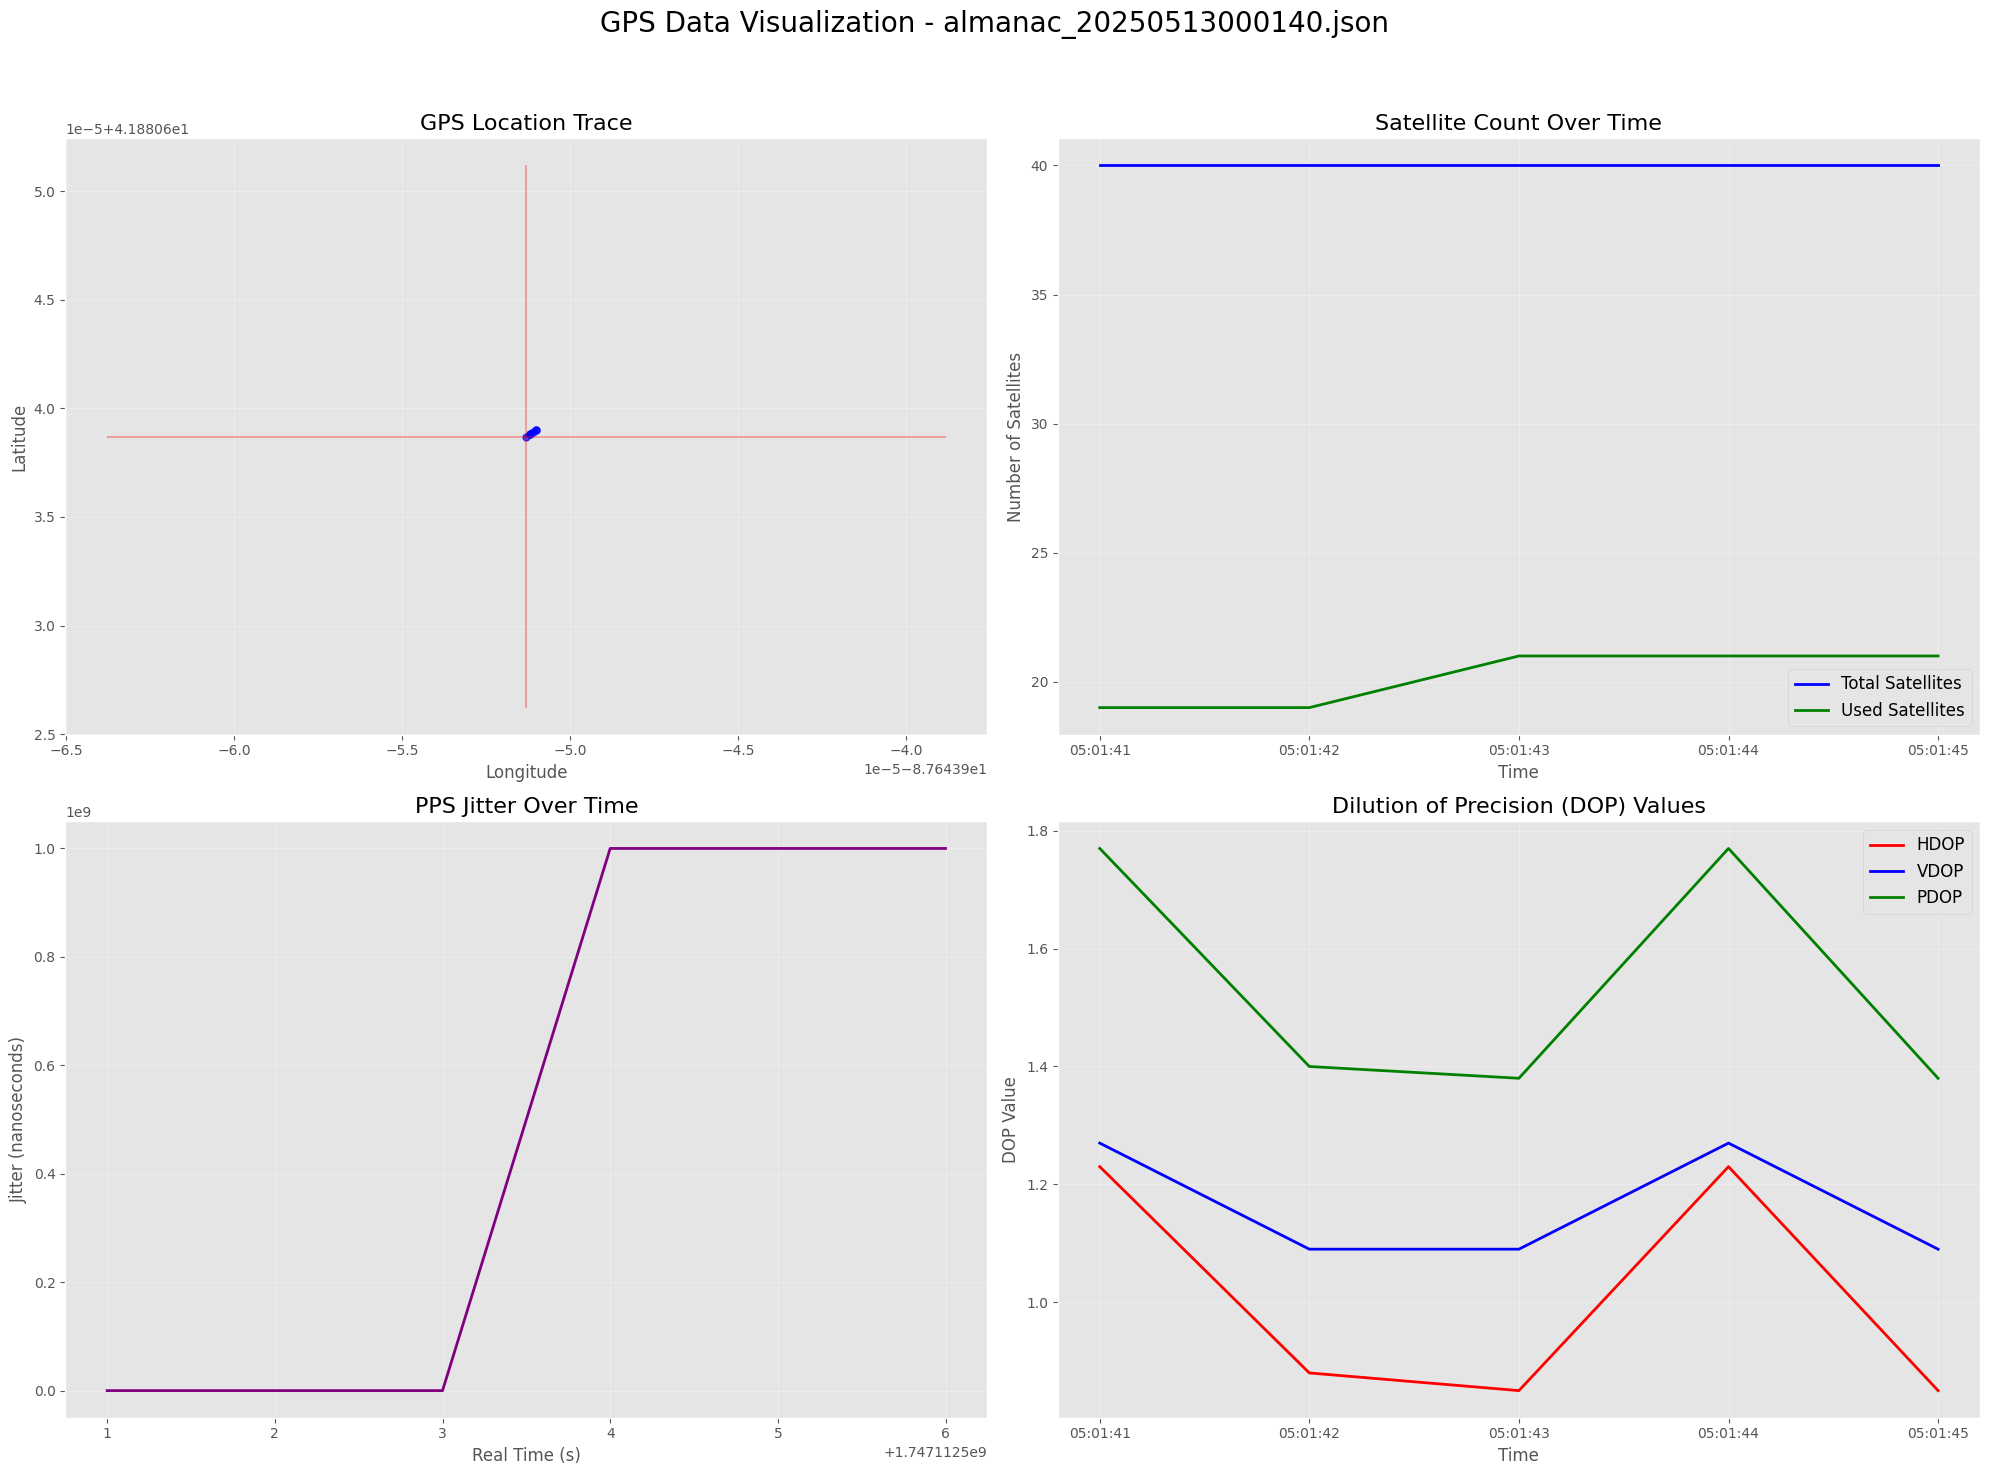


Statistics:
TPV Records: 6
SKY Records: 5
Average satellites visible: 40.00
Average satellites used: 20.20
PPS Records: 6
Average jitter: 500000458.67 ns

--------------------------------------------------

## Visualizing: almanac_20250513120001.json ##


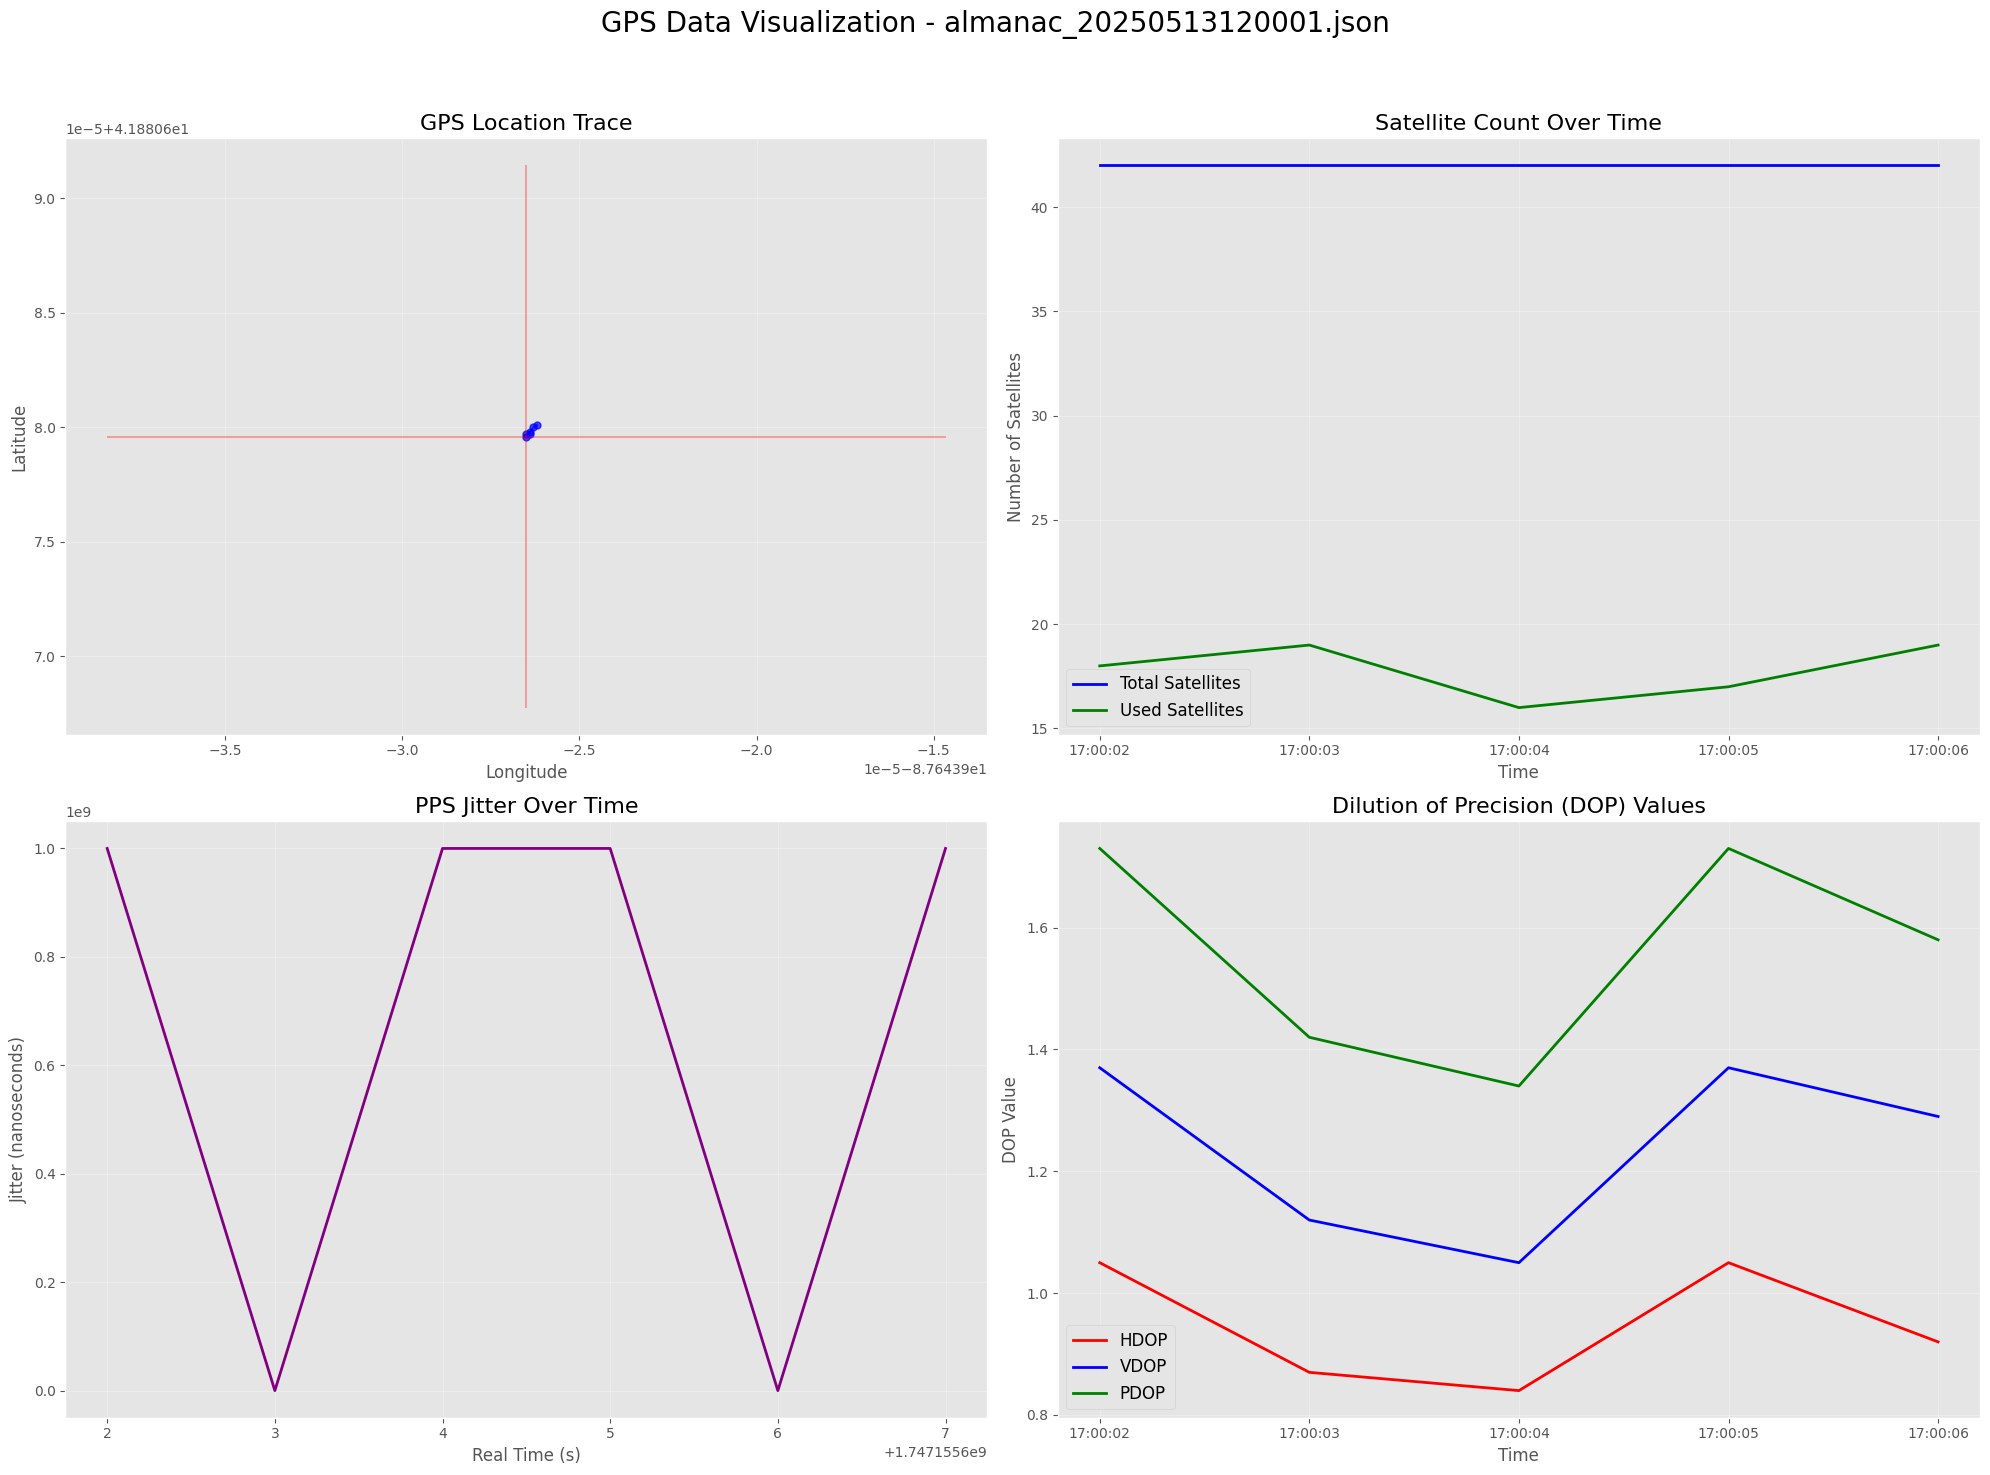


Statistics:
TPV Records: 6
SKY Records: 5
Average satellites visible: 42.00
Average satellites used: 17.80
PPS Records: 6
Average jitter: 666666291.67 ns

--------------------------------------------------

## Visualizing: almanac_20250514000001.json ##


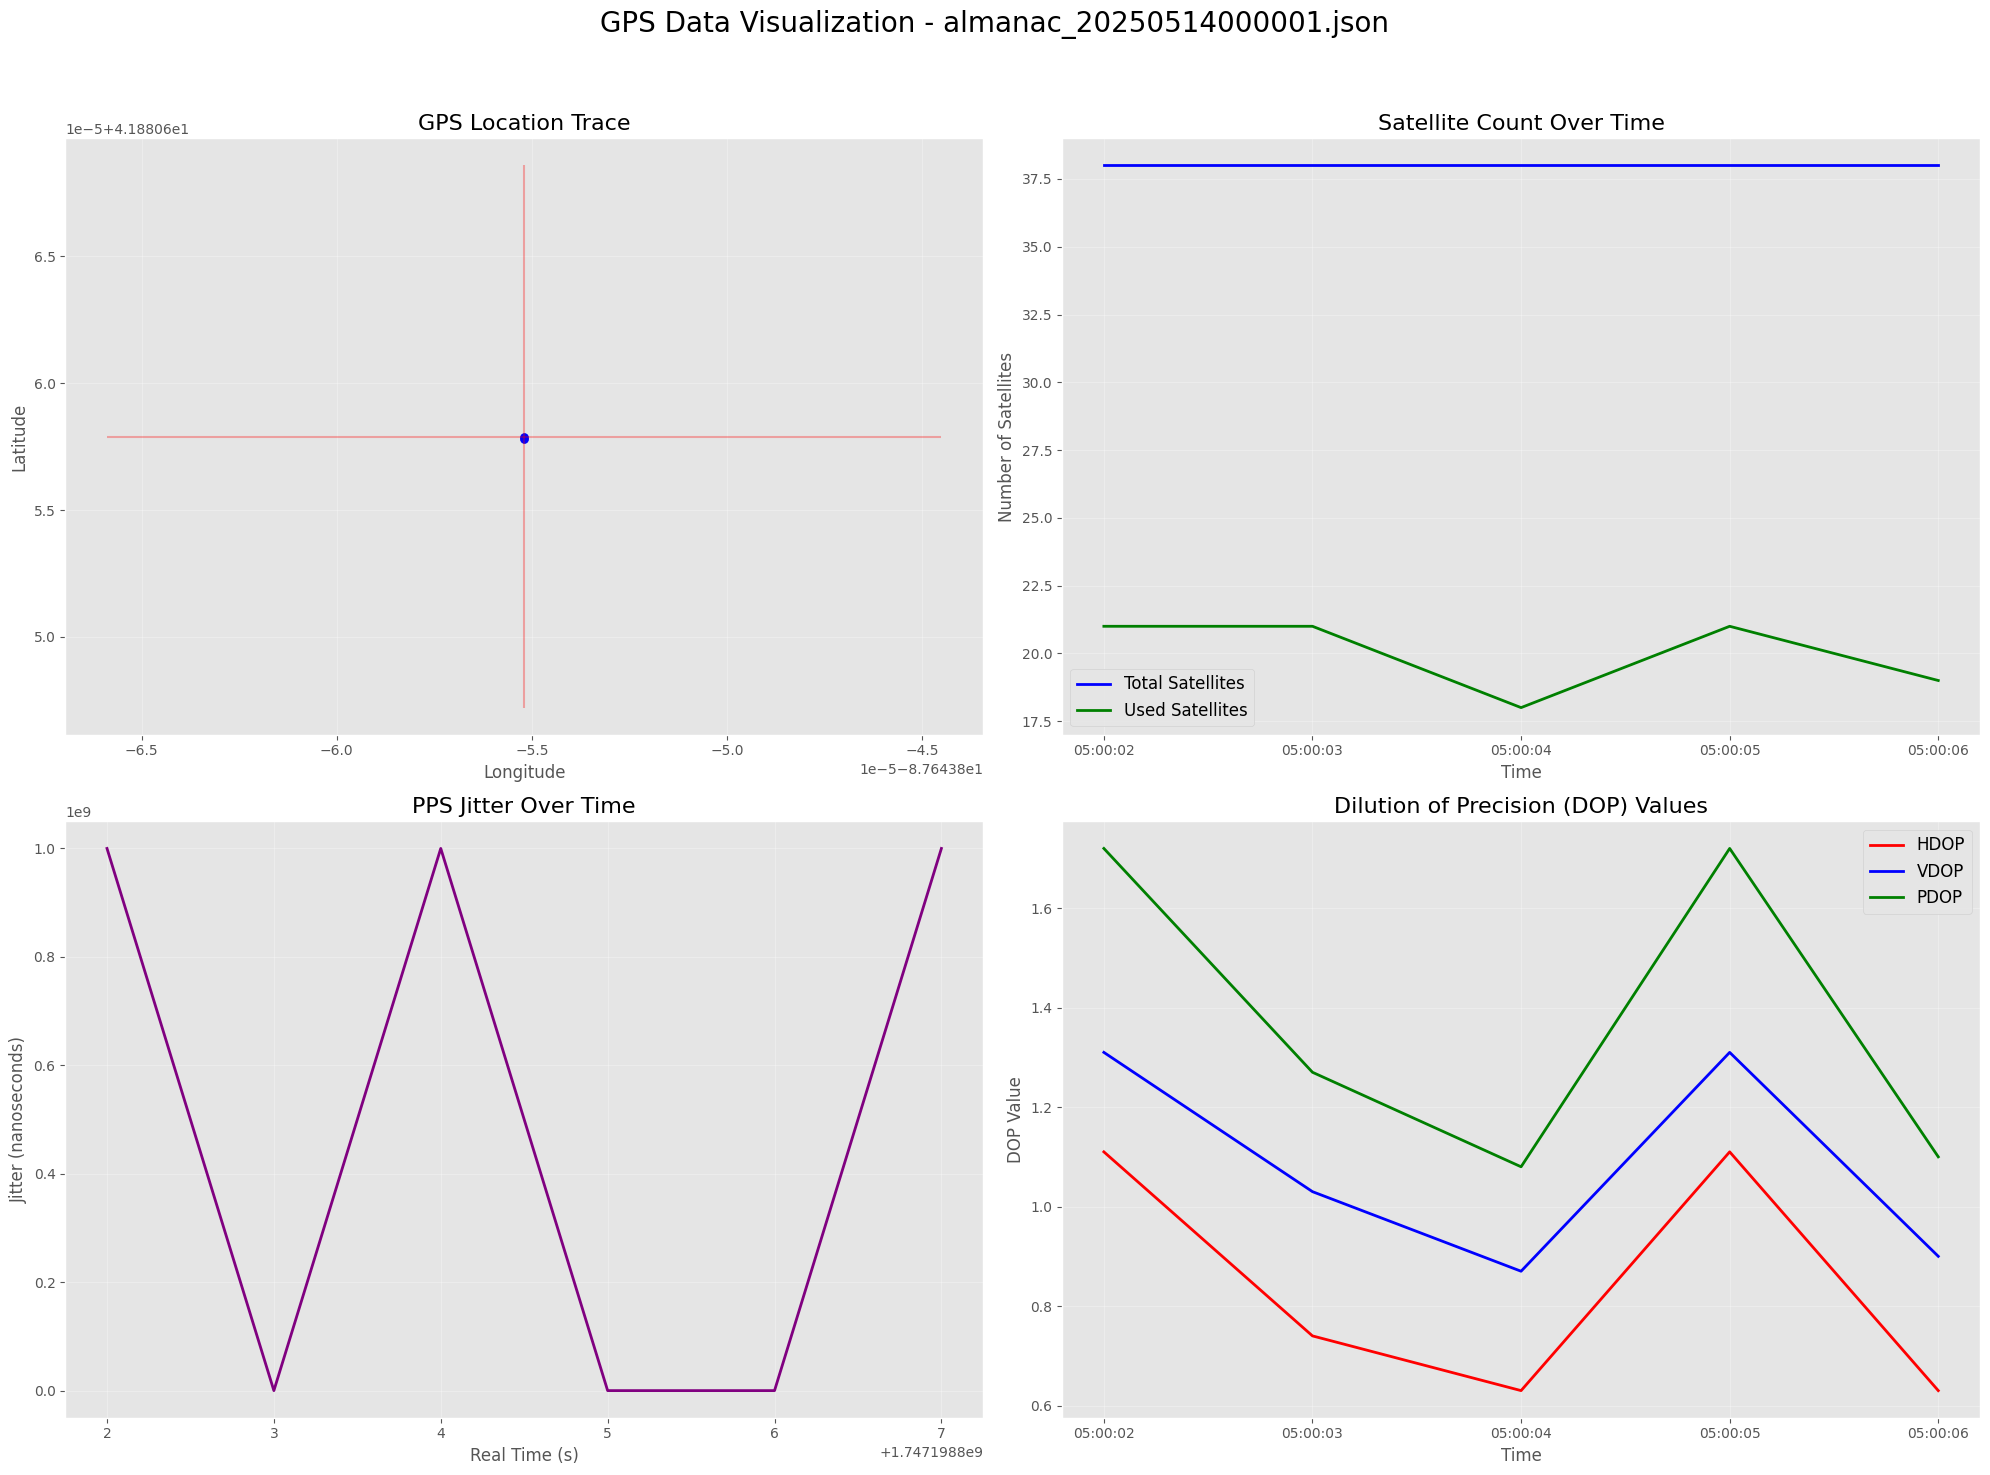


Statistics:
TPV Records: 6
SKY Records: 5
Average satellites visible: 38.00
Average satellites used: 20.00
PPS Records: 6
Average jitter: 500000152.83 ns

--------------------------------------------------

## Visualizing: almanac_20250514120001.json ##


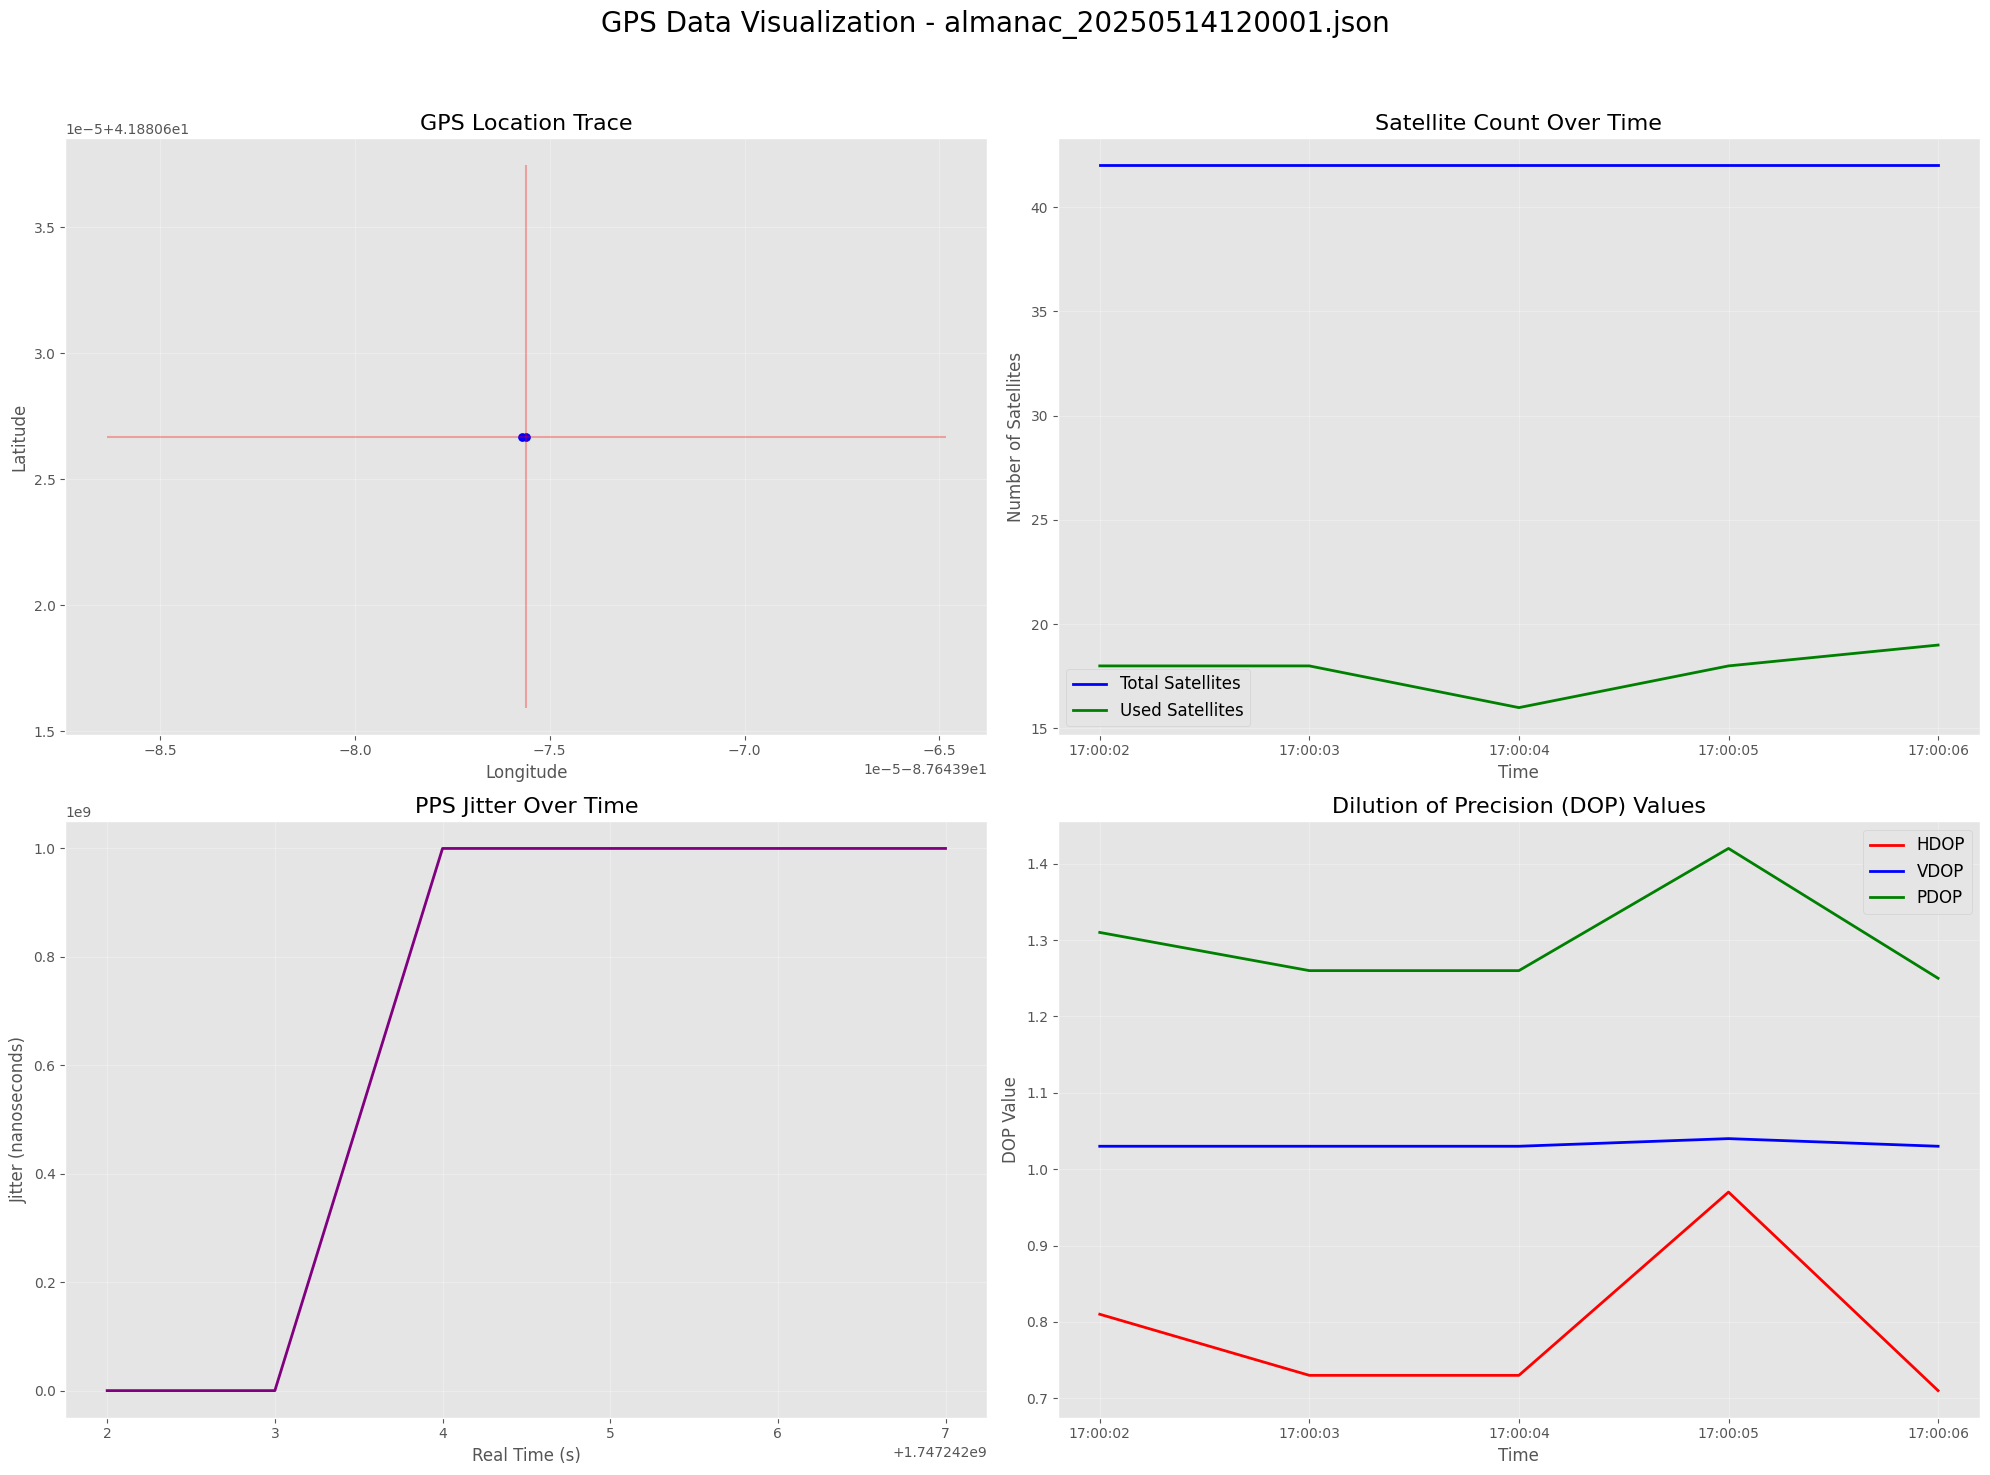


Statistics:
TPV Records: 6
SKY Records: 5
Average satellites visible: 42.00
Average satellites used: 17.80
PPS Records: 6
Average jitter: 666666741.33 ns

--------------------------------------------------

## Visualizing: almanac_20250515000001.json ##


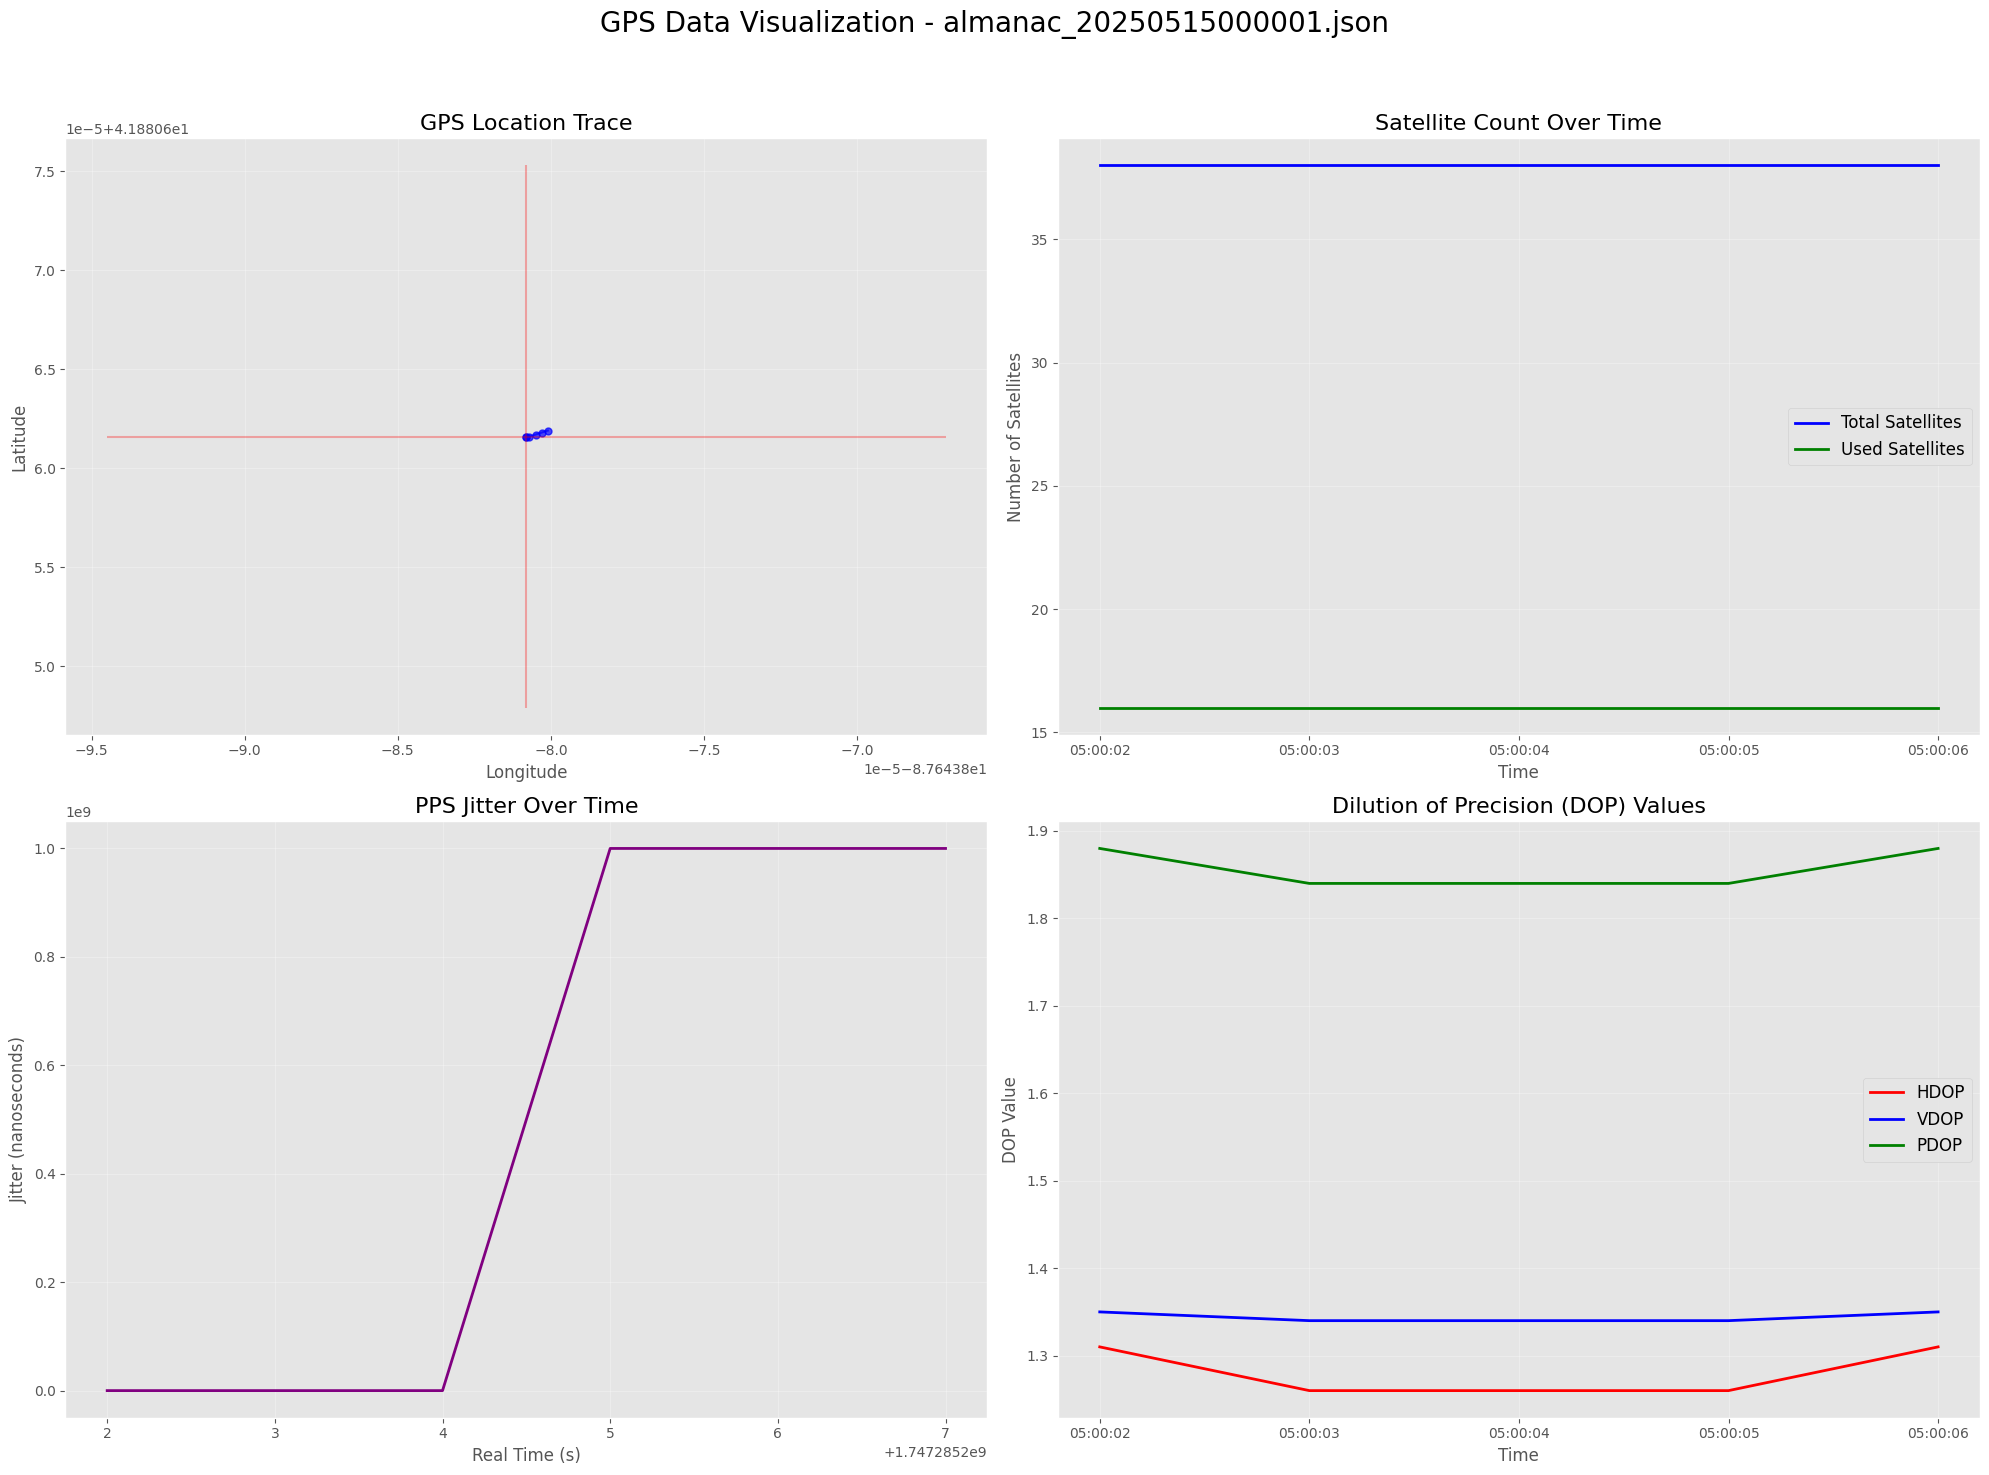


Statistics:
TPV Records: 6
SKY Records: 5
Average satellites visible: 38.00
Average satellites used: 16.00
PPS Records: 6
Average jitter: 499999331.00 ns

--------------------------------------------------

## Visualizing: gps_log.json ##


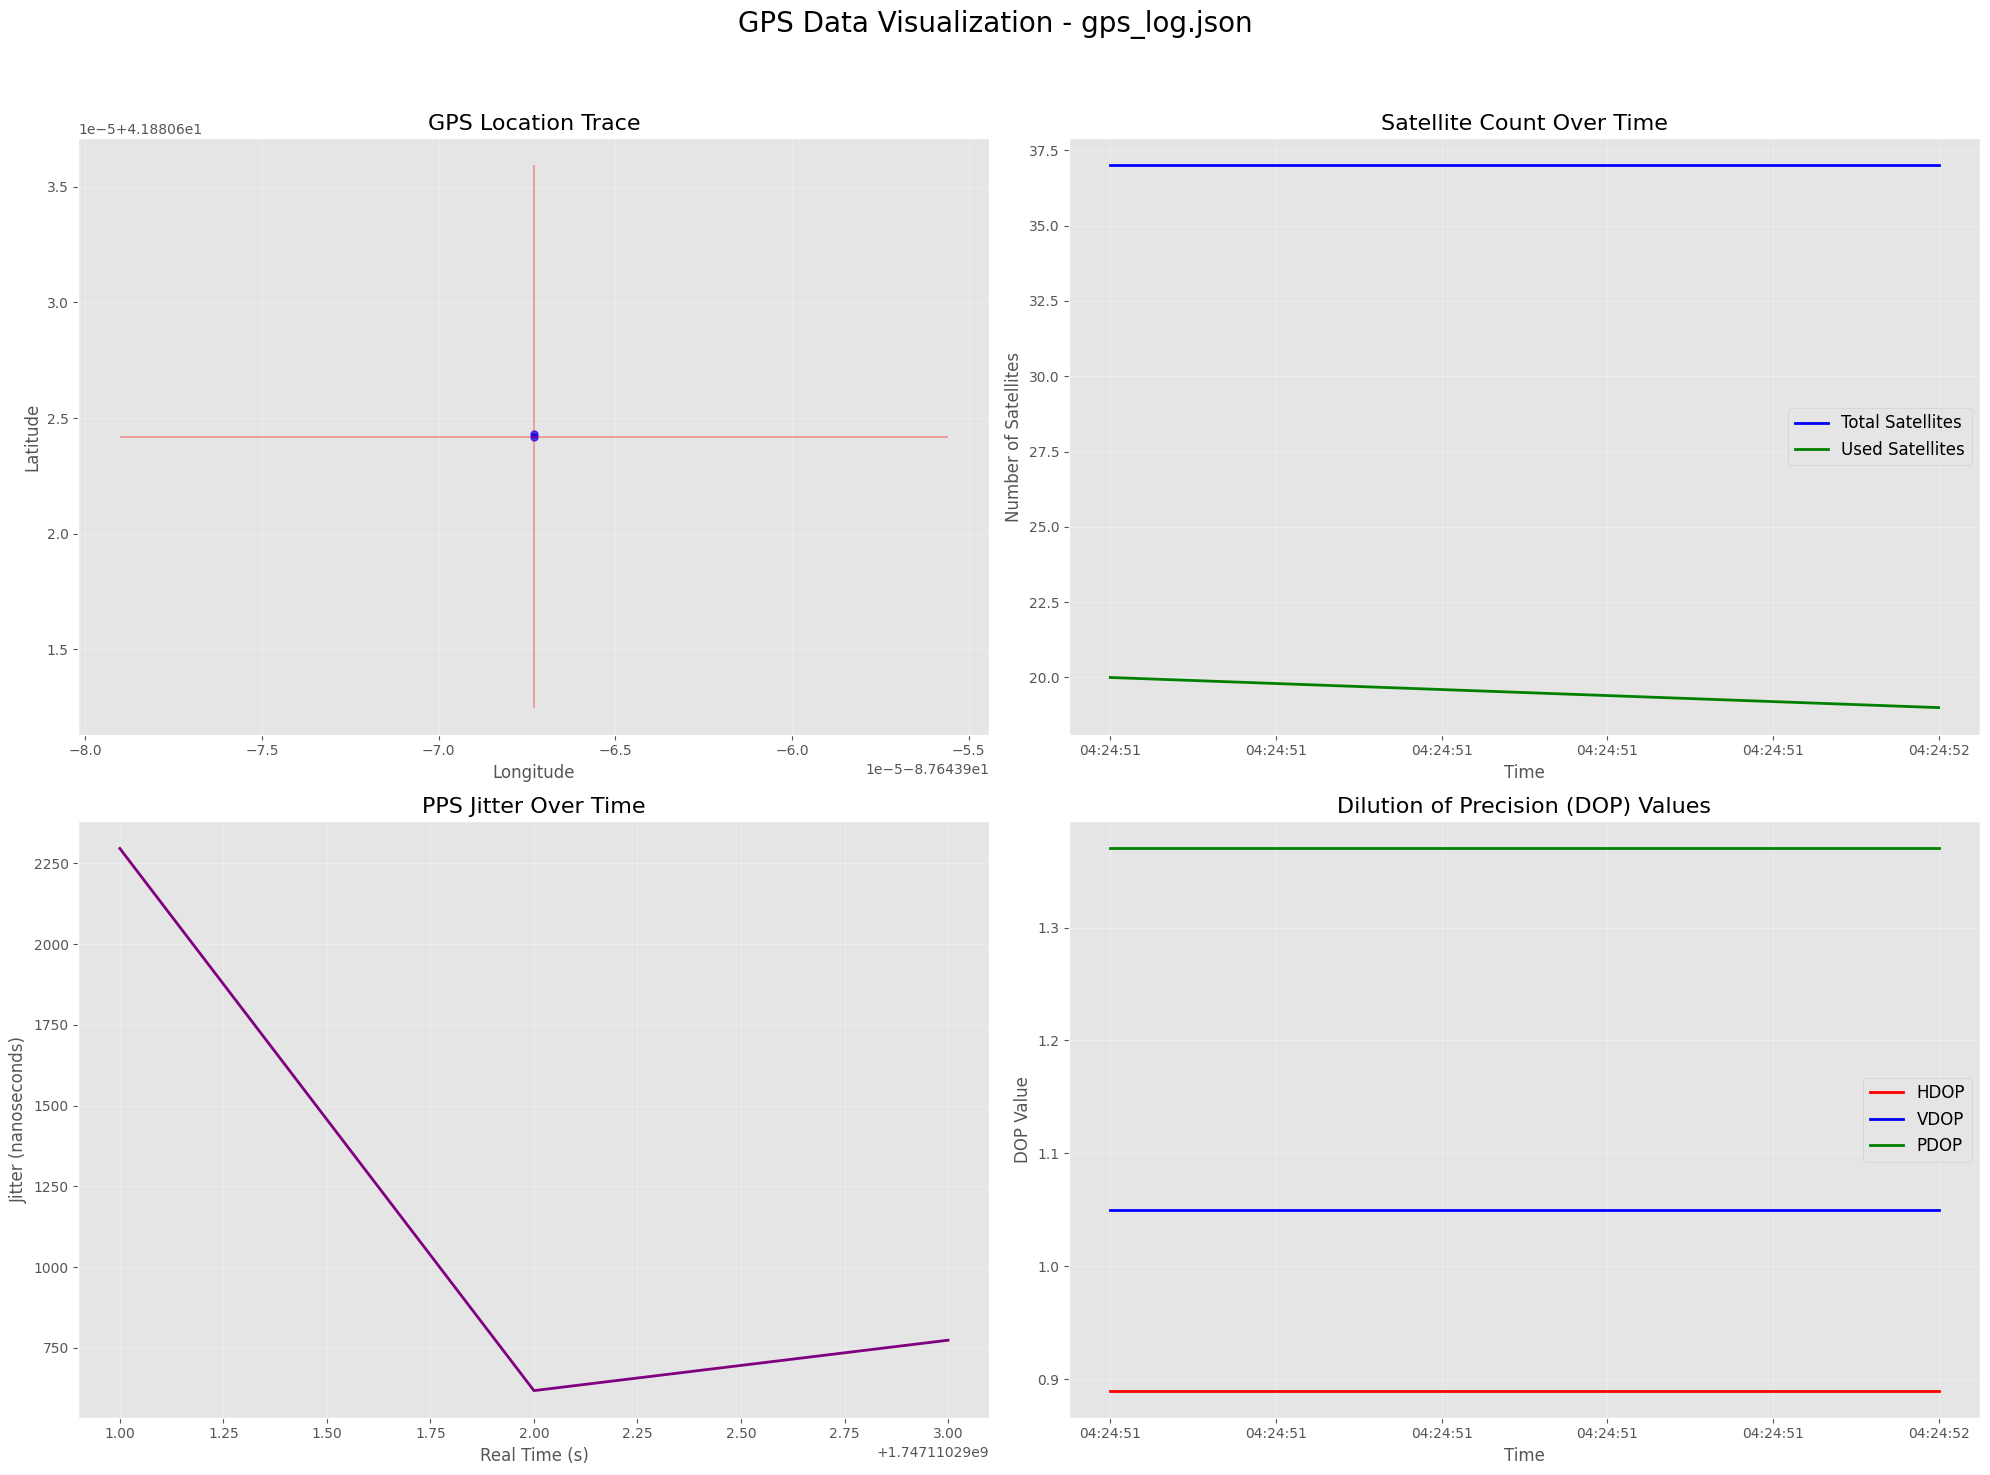


Statistics:
TPV Records: 2
SKY Records: 2
Average satellites visible: 37.00
Average satellites used: 19.50
PPS Records: 3
Average jitter: 1229.33 ns

--------------------------------------------------

## Visualizing: gpt_log_boddeti2.json ##


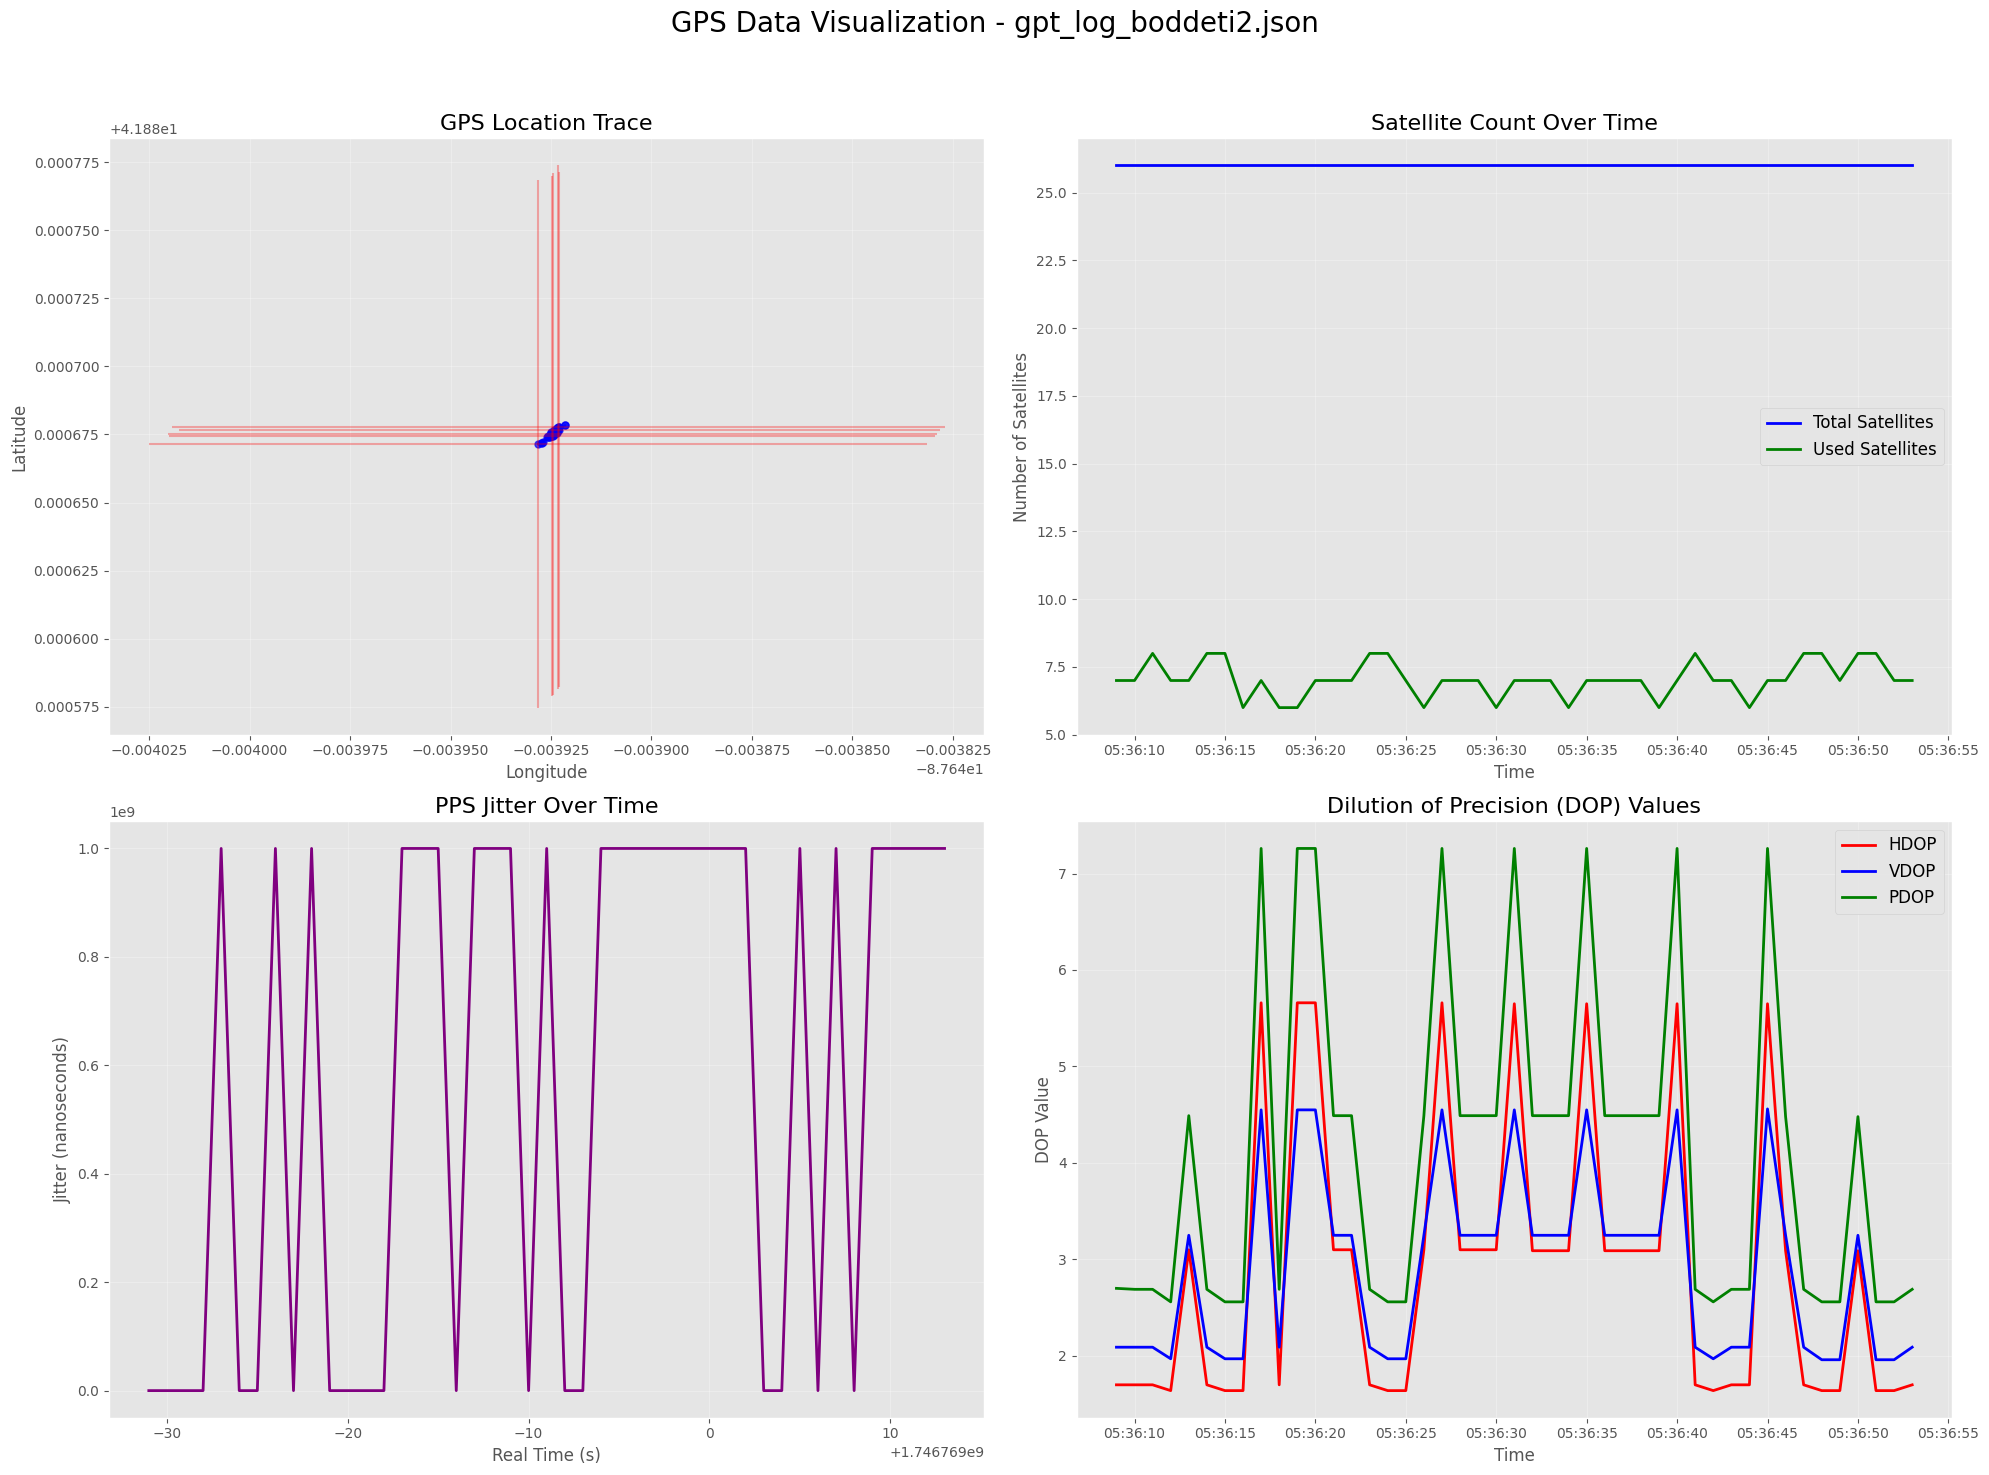


Statistics:
TPV Records: 45
SKY Records: 45
Average satellites visible: 26.00
Average satellites used: 7.04
PPS Records: 45
Average jitter: 577777682.89 ns

--------------------------------------------------


In [13]:
# Process each file individually
for file_path in json_files:
    try:
        plot_gps_data(file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

## Conclusion

This notebook has visualized GPS data from multiple log files, showing both aggregate statistics and individual log details. The visualizations include:

1. GPS location traces
2. Satellite count over time
3. PPS jitter measurements
4. Dilution of Precision (DOP) values

These visualizations help in understanding the quality and characteristics of the GPS data collected.